<a href="https://colab.research.google.com/github/Tolgadnc/DeepLearningCourse/blob/Bekta%C5%9F-tried-tokenizer-and-then-turned-it-back/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import random
import pandas as pd
import json
import pickle
import torch.utils.data
import json
import math
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.utils.data import Dataset, DataLoader
import random
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer
import json
import os

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, image_dir, transform, tokenizer, max_len=15):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data) * 3  # Assuming 3 captions per image

    def __getitem__(self, idx):
        original_idx = idx // 3
        caption_idx = idx % 3

        item = self.data[original_idx]
        img_path = os.path.join(self.image_dir, item['filename'])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Tokenize caption with <SOS> and <EOS>
        caption = item['sentences'][caption_idx]
        encoded_caption = self.tokenizer.encode(
            caption,
            add_special_tokens=False,  # Disable BERT's default special tokens
            max_length=self.max_len - 2,  # Reserve space for <SOS> and <EOS>
            padding="max_length",
            truncation=True,
        )
        encoded_caption = [tokenizer.bos_token_id] + encoded_caption + [tokenizer.eos_token_id]
        encoded_caption = encoded_caption[:self.max_len]  # Ensure max_len
        encoded_caption += [tokenizer.pad_token_id] * (self.max_len - len(encoded_caption))  # Pad if necessary

        return image, torch.tensor(encoded_caption)


In [ ]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Add special tokens
tokenizer.add_special_tokens(
    {"pad_token": "<PAD>", "unk_token": "<UNK>", "bos_token": "<SOS>", "eos_token": "<EOS>"}
)

# Verify that the special tokens have been added
sos_token_id = tokenizer.convert_tokens_to_ids("<SOS>")
eos_token_id = tokenizer.convert_tokens_to_ids("<EOS>")
pad_token_id = tokenizer.pad_token_id
unk_token_id = tokenizer.unk_token_id

print(f"<SOS> token ID: {sos_token_id}")
print(f"<EOS> token ID: {eos_token_id}")
print(f"<PAD> token ID: {pad_token_id}")
print(f"<UNK> token ID: {unk_token_id}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<SOS> token ID: 30524
<EOS> token ID: 30525
<PAD> token ID: 30522
<UNK> token ID: 30523


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/Image Captioning/flickr8k_simplified.json", "r") as file:
    data = json.load(file)

image_dir = "/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset_reduced_size"

# with open("/content/drive/MyDrive/Deep_Learning/flickr8k_simplified.json", "r") as file:
#     data = json.load(file)

# image_dir = "/content/drive/MyDrive/Deep_Learning/Resized_Images"

train_data = [item for item in data if item["split"] == "train"]
train_dataset = ImageCaptionDataset(train_data, image_dir, transform, tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
val_data = [item for item in data if item['split'] == 'val']
test_data = [item for item in data if item['split'] == 'test']

In [ ]:
val_dataset = ImageCaptionDataset(val_data, image_dir, transform, tokenizer)
test_dataset = ImageCaptionDataset(test_data, image_dir, transform, tokenizer)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Fetch a batch from the DataLoader
images, labels = next(iter(train_dataloader))

# Decode a few captions
for i in range(5):
    tokenized_caption = labels[i].tolist()
    decoded_caption = tokenizer.decode(tokenized_caption, skip_special_tokens=False)  # Include special tokens
    print(f"Sample {i+1}:")
    print(f"Tokenized: {tokenized_caption}")
    print(f"Decoded Caption: {decoded_caption}")
    print()


Sample 1:
Tokenized: [30524, 1037, 2210, 2879, 2003, 2770, 2006, 1996, 2461, 2652, 2007, 1037, 2210, 2611, 30525]
Decoded Caption: <SOS> a little boy is running on the round playing with a little girl <EOS>

Sample 2:
Tokenized: [30524, 1037, 4306, 1997, 2111, 2024, 5935, 1999, 1996, 2395, 12015, 3493, 9245, 1012, 30525]
Decoded Caption: <SOS> a crowd of people are gathered in the street waving irish flags. <EOS>

Sample 3:
Tokenized: [30524, 1037, 17260, 6277, 2121, 1999, 1996, 2250, 2012, 1996, 2327, 1997, 13276, 1012, 30525]
Decoded Caption: <SOS> a skateboarder in the air at the top of ramp. <EOS>

Sample 4:
Tokenized: [30524, 1037, 2775, 13956, 2049, 2227, 2039, 2875, 1037, 3332, 1997, 1037, 14705, 1012, 30525]
Decoded Caption: <SOS> a child pushes its face up towards a window of a playground. <EOS>

Sample 5:
Tokenized: [30524, 1037, 2158, 2007, 1037, 2304, 6045, 7719, 2114, 1037, 5318, 2311, 1012, 30522, 30525]
Decoded Caption: <SOS> a man with a black hat sits against a brick b

In [ ]:
vocab_size = len(tokenizer)  # The total number of tokens in the tokenizer's vocabulary
print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 30526


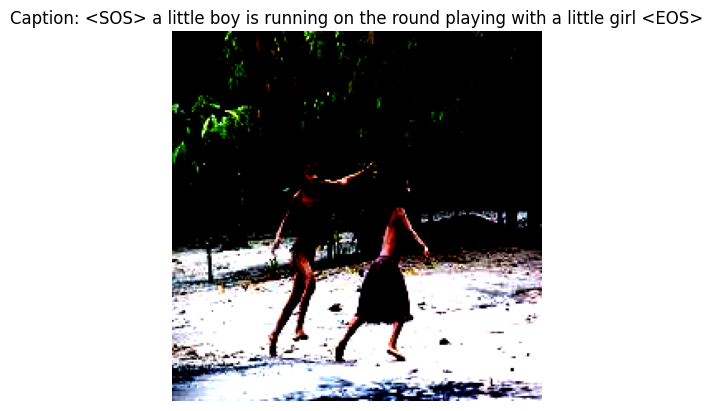

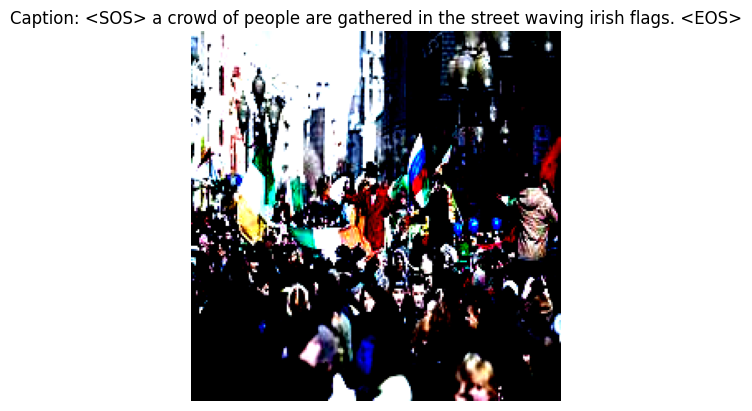

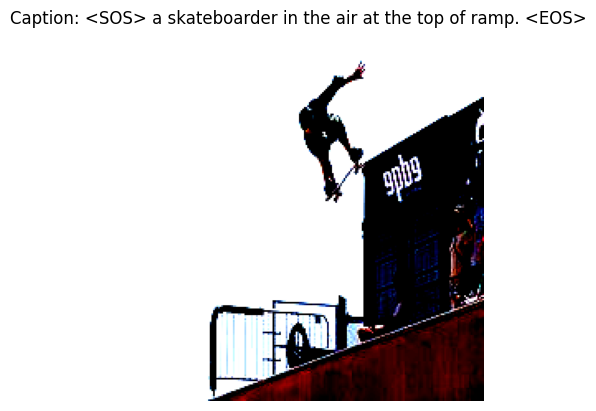

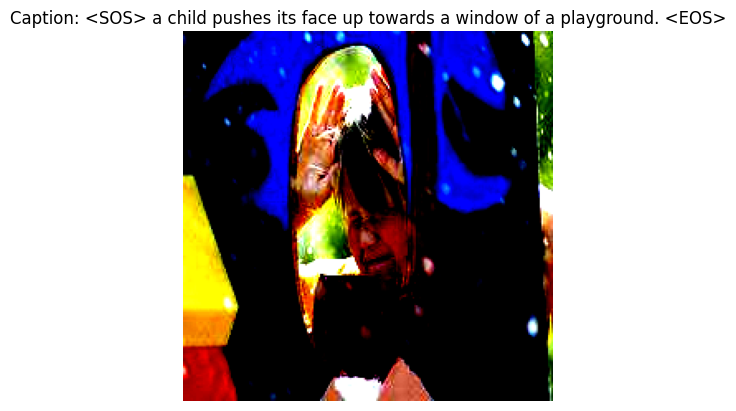

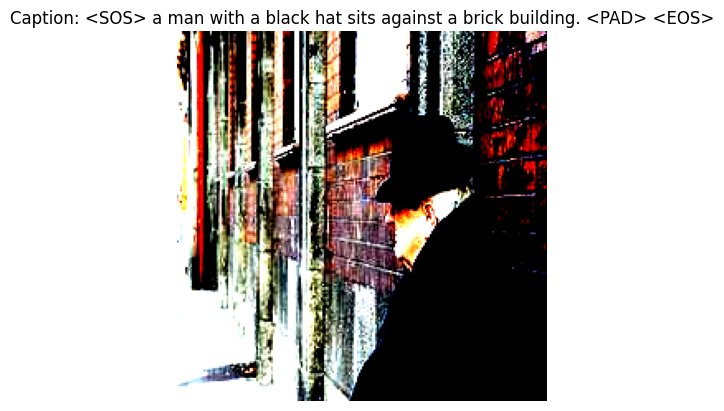

In [ ]:
import matplotlib.pyplot as plt

for i in range(5):  # Display the first 5 samples
    plt.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.axis("off")
    plt.title(f"Caption: {tokenizer.decode(labels[i].tolist(), skip_special_tokens=False)}")
    plt.show()


Visualizing samples from training dataset:


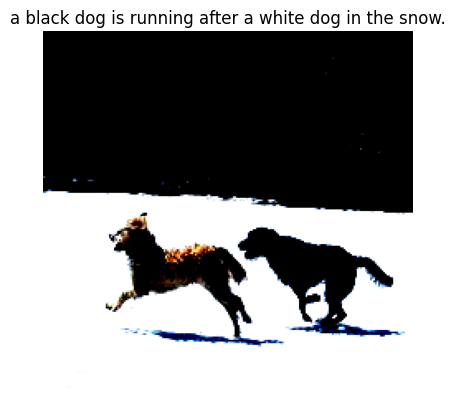

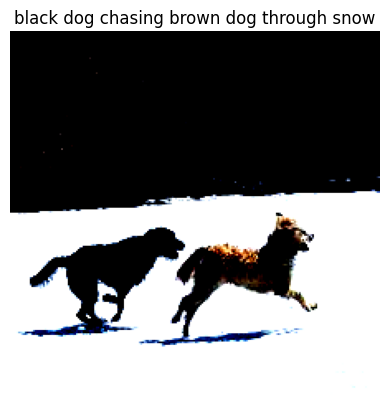

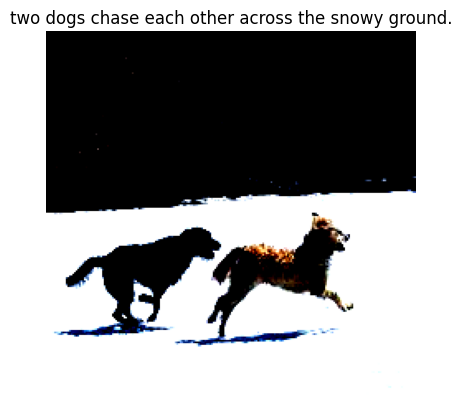

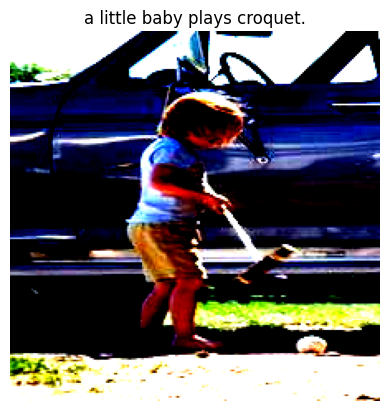

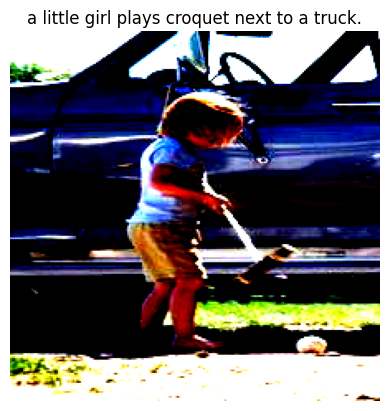

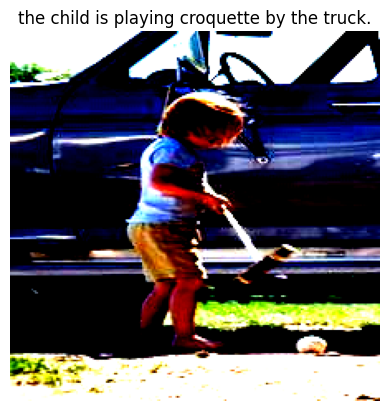

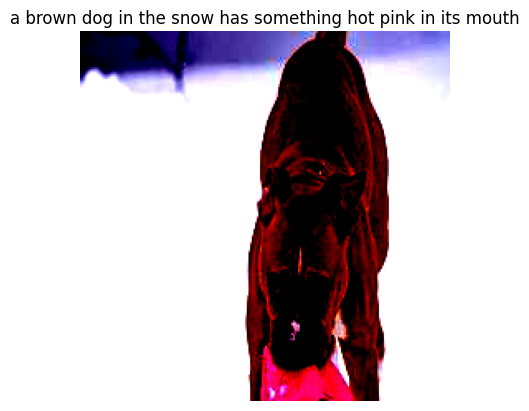

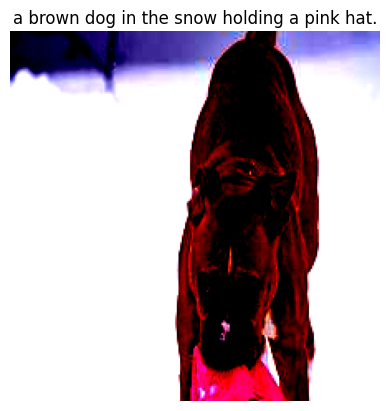

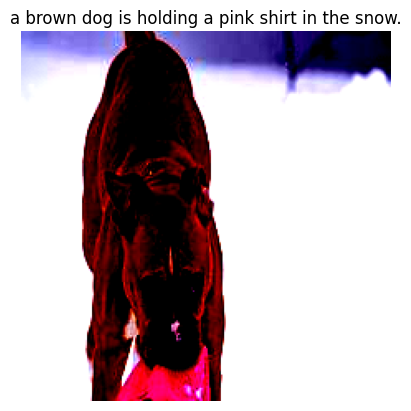

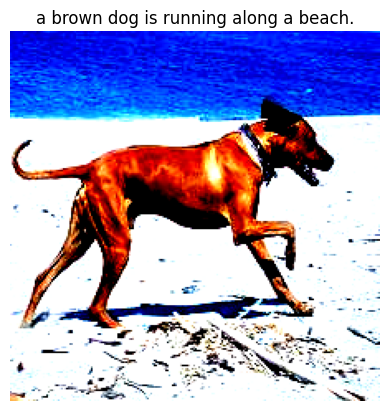

In [ ]:
def visualize_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, caption = dataset[i]
        decoded_caption = tokenizer.decode(caption.numpy(), skip_special_tokens=True)

        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title(decoded_caption)
        plt.axis('off')
        plt.show()

# Visualize before training
print("Visualizing samples from training dataset:")
visualize_samples(train_dataset, num_samples=10)

In [ ]:
class Patchify(nn.Module):

    def __init__(self, img_size, patch_size, embed_dim, in_channels = 3):
        super().__init__()
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels

        self.proj = nn.Conv2d(in_channels,
                              out_channels = self.embed_dim,
                              kernel_size = self.patch_size,
                              stride = self.patch_size)

    def forward(self, x): # x represent input image tensor.
        B, C, H, W = x.shape # B: batch size, C: Number of channels (3 for RGB), H and W: Height and Weight (224 X 224)
        assert H % self.patch_size == 0 and W % self.patch_size == 0, "Image size must be divisible by patch size"
        x = self.proj(x)   # (batch_size, dim, img_size // patch_size, img_size // patch_size)
        # the input to the transformer should be of shape (batch_size, num_patches, embedding dim)
        # (batch_size, dim, img_size // patch_size, img_size // patch_size) --> flattten --> (batch_size, dim, num_patches) --> tranpose --> (batch_size, num_patches, dim)
        x = x.flatten(2).transpose(1,2)
        return x

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#Turend back to post-LN(previous version is in github no worries. https://github.com/Tolgadnc/DeepLearningCourse.git)
class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                MultiHeadAttention(dim, heads=heads, dropout=dropout, mask=False),
                nn.LayerNorm(dim),
                FeedForward(dim, dropout=dropout),
                nn.LayerNorm(dim),
            ]) for _ in range(num_layers)
        ])

    def forward(self, x):
        for attn, norm1, ff, norm2 in self.layers:
            # Multi-Head Attention with Post-LayerNorm
            attn_output = attn(x)  # Apply Multi-Head Attention
            x = x + attn_output  # Add residual connection
            x = norm1(x)  # Normalize after attention

            # FeedForward Network with Post-LayerNorm
            ffn_output = ff(x)  # Apply FeedForward
            x = x + ffn_output  # Add residual connection
            x = norm2(x)  # Normalize after feedforward

        return x


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2) * -(math.log(10000.0) / dim_model))

        pe = torch.zeros(1, max_len, dim_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [ ]:
class ViTEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embed_dim, num_layers, heads, dropout):
        super().__init__()

        self.patchify = Patchify(image_size, patch_size, embed_dim)
        self.max_words = self.patchify.num_patches
        self.pos_encoding = nn.Parameter(torch.randn(1, self.max_words,  embed_dim))
        self.transformer = Transformer(embed_dim, num_layers, heads, dropout=dropout)

    def forward(self, x):
        x = self.patchify(x)         # (batch_size, num_patches, dim)
        x = x + self.pos_encoding[:, :x.size(1), :] # Added dynamic size adjusting here so that the images can be randomly cropped
        x = self.transformer(x)      # Pass through Transformer
        return x                     # Return encoded patches (batch_size, num_patches, dim)


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads, dropout, mask):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.mask = mask

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)
        self.out_proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_outputs=None):


        B, N, C = x.shape
        x = self.norm(x)

        query = self.query(x)  # (B, N, C)
        key = self.keys(x if encoder_outputs is None else encoder_outputs)  # (B, N_patches or seq_len, C)
        value = self.values(x if encoder_outputs is None else encoder_outputs)  # Same as key

        dim_head = C // self.heads


        query = query.reshape(B, N, self.heads, dim_head).permute(0, 2, 1, 3)
        key = key.reshape(B, -1, self.heads, dim_head).permute(0, 2, 1, 3)
        value = value.reshape(B, -1, self.heads, dim_head).permute(0, 2, 1, 3)


        attention_scores = torch.matmul(query, key.transpose(-1, -2)) * (dim_head ** -0.5)

        # Apply mask
        if self.mask:
            seq_length = attention_scores.size(-1)
            causal_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)
            attention_scores = attention_scores.masked_fill(causal_mask, float("-inf"))

        attention_probs = F.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)


        out = torch.matmul(attention_probs, value)


        out = out.permute(0, 2, 1, 3).reshape(B, N, C)
        out = self.out_proj(out)
        return out


In [ ]:
#Turend back to post-LN(previous version is in github no worries. https://github.com/Tolgadnc/DeepLearningCourse.git)
class TransformerWithMask(nn.Module):
    def __init__(self, dim, num_layers, heads, vocab_size, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                MultiHeadAttention(dim, heads, dropout, mask=True),
                nn.LayerNorm(dim),
                MultiHeadAttention(dim, heads, dropout, mask=False),
                nn.LayerNorm(dim),
                FeedForward(dim, dropout),
                nn.LayerNorm(dim),
            ])
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_outputs):
        for masked_attn, norm1, cross_attn, norm2, ff, norm3 in self.layers:
            # Masked Self-Attention with Post-LayerNorm
            attn_output = masked_attn(x)
            x = x + attn_output  # Residual connection
            x = norm1(x)  # Post-LN

            # Cross-Attention with Post-LayerNorm
            cross_attn_output = cross_attn(x, encoder_outputs)
            x = x + cross_attn_output  # Residual connection
            x = norm2(x)  # Post-LN

            # FeedForward with Post-LayerNorm
            ffn_output = ff(x)
            x = x + ffn_output  # Residual connection
            x = norm3(x)  # Post-LN

        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dim_model, n_head, num_layers, vocab_size, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, dropout)
        self.dropout = nn.Dropout(dropout)  # Dropout after positional encoding
        self.linear = nn.Linear(dim_model, vocab_size)
        self.transformer = TransformerWithMask(dim_model, num_layers, n_head, dropout)

    def forward(self, captions, encoder_outputs):
        # Embed captions
        x = self.embedding(captions)

        # Add positional encoding
        x = self.positional_encoding(x)

        x = self.dropout(x)
        # Pass through transformer
        x = self.transformer(x, encoder_outputs)

        return self.linear(x)

In [ ]:
# This class used to define encoder and decoder for the whole transformer structure
class ImageCaptioning(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_layers, heads, vocab_size, max_len, dropout=0.1):
        super().__init__()

        self.encoder = ViTEncoder(img_size, patch_size, embed_dim, num_layers, heads, dropout)
        self.decoder = Decoder(embed_dim, heads,num_layers,vocab_size, dropout)

    def forward(self, captions, images):
        # Encode image patches
        encoder_out = self.encoder(images)  # (batch_size, num_patches, embed_dim)

        # Decode captions using the encoder outputs|
        decode_out = self.decoder(captions, encoder_out)  # (batch_size, max_len, vocab_size)

        return decode_out


In [ ]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR



# Training Function
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, captions in loader:
        images, captions = images.to(device), captions.to(device)
        inputs, targets = captions[:, :-1], captions[:, 1:]
        outputs = model(inputs, images)
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Validation Function
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in loader:
            images, captions = images.to(device), captions.to(device)
            inputs, targets = captions[:, :-1], captions[:, 1:]
            outputs = model(inputs, images)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

# Warm-Up + Cosine Annealing Scheduler
def get_scheduler_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Linear warm-up
            return float(current_step) / float(max(1, num_warmup_steps))
        # Cosine annealing
        progress = (current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return 0.5 * (1.0 + torch.cos(torch.pi * progress))

    return LambdaLR(optimizer, lr_lambda)

num_epochs = 50
# Model
model = ImageCaptioning(
    img_size=224, patch_size=16, embed_dim=768, num_layers=5, heads=6, vocab_size=vocab_size, max_len=15,
    dropout=0.5).to(device)

# Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define total training steps and warm-up steps
num_training_steps = len(train_dataloader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)  # Warm-up for the first 10% of training

scheduler = get_scheduler_with_warmup(optimizer, num_warmup_steps, num_training_steps)

train_losses = []
val_losses = []

# Training Loop
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    train_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")

    val_loss = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update the scheduler after each epoch
    scheduler.step()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


Epoch 1/50
Training Loss: 10.5447
Validation Loss: 10.5740
Epoch 2/50
Training Loss: 10.3536
Validation Loss: 10.0800
Epoch 3/50
Training Loss: 9.7676
Validation Loss: 9.1380
Epoch 4/50
Training Loss: 8.8999
Validation Loss: 8.3127
Epoch 5/50


In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# def load_checkpoint(path, model, optimizer, scheduler):
#     checkpoint = torch.load(path)
#     model.load_state_dict(checkpoint["model_state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
#     scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
#     start_epoch = checkpoint["epoch"] + 1
#     train_losses = checkpoint["train_losses"]
#     val_losses = checkpoint["val_losses"]
#     return start_epoch, train_losses, val_losses

In [ ]:
# model = ImageCaptioning(
#     img_size=224, patch_size=16, embed_dim=768, num_layers=6, heads=8, vocab_size=vocab_size, max_len=20,
#     dropout=0.5).to(device)

# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [ ]:
# resume_checkpoint = "/content/drive/MyDrive/Image Captioning/checkpoints/epoch_5.pth"

In [ ]:
# if resume_checkpoint:
#     if os.path.exists(resume_checkpoint):
#         start_epoch, train_losses, val_losses = load_checkpoint(resume_checkpoint, model, optimizer, scheduler)
#         print(f"Resumed training from epoch {start_epoch}")
#     else:
#         print(f"Checkpoint not found at {resume_checkpoint}")
# else:
#     print("No checkpoint path specified.")

In [ ]:
model.eval()

# Select a test image by index
index_test_image = 30
test_images, gt_captions = next(iter(test_loader))
input_test_img = test_images[index_test_image].unsqueeze(0).to(device)

# Start the decoding process with the <SOS> token
decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
predicted_caption = []

# Generate the caption
with torch.no_grad():
    for _ in range(20):  # Max caption length
        outputs = model(decoder_input, input_test_img)  # Forward pass
        next_word = outputs[:, -1, :].argmax(dim=-1)  # Select the last predicted word
        predicted_caption.append(next_word.item())  # Append predicted word to the caption
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(0)], dim=1)  # Add next word to input


# Decode the predicted and ground truth captions
predicted_caption_text = tokenizer.decode(predicted_caption, skip_special_tokens=True)
ground_truth_caption_text = tokenizer.decode(gt_captions[index_test_image].cpu().numpy(), skip_special_tokens=True)

# Visualize the image with the predicted and ground truth captions
plt.imshow(test_images[index_test_image].permute(1, 2, 0).cpu().numpy())
plt.title(f"Predicted: {predicted_caption_text}\nGround Truth: {ground_truth_caption_text}")
plt.axis('off')
plt.show()


# Model Output Evaluation

In [ ]:
!pip install bert_score
!pip install git+https://github.com/michelecafagna26/cider.git#egg=cidereval

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from bert_score import score
from cidereval import cider, ciderD

In [ ]:
model.eval()
index_test_image = 30
predicted_captions = []
ground_truth_captions = []

# Get a batch of test images
test_images, gt_captions = next(iter(test_loader))

for i in range(index_test_image):
  input_test_img = test_images[i].unsqueeze(0).to(device)

  decoder_input = torch.tensor([[tokenizer.bos_token_id]], device=device)
  predicted_caption = []

  with torch.no_grad():
      for _ in range(20):  # Max caption length
          outputs = model(decoder_input, input_test_img)
          next_word = outputs.argmax(dim=-1)[:, -1]
          predicted_caption.append(next_word.item())
          decoder_input = torch.cat([decoder_input, next_word.unsqueeze(0)], dim=1)
          if next_word.item() == tokenizer.eos_token_id:
              break

  predicted_caption = tokenizer.decode(predicted_caption, skip_special_tokens=True)
  ground_truth_caption = tokenizer.decode(gt_captions[i].cpu().numpy(), skip_special_tokens=True)

  predicted_captions.append(predicted_caption)
  ground_truth_captions.append(ground_truth_caption)

In [ ]:
predicted_sentences = []
true_sentences = []

for i in ground_truth_captions:
  sentence = [i.lower().replace('.', '').strip()]
  true_sentences.append(sentence)
for i in predicted_captions:
    sentence = [i.lower().replace('.', '').strip()]
    predicted_sentences.append(sentence)

Tokenize the sentences

In [ ]:
predicted_sentences_tokenized = []

for i in predicted_sentences:
  sentences = []
  for j in i:
    sentences.append(j.split())
  predicted_sentences_tokenized.append(sentences)

In [ ]:
print(predicted_sentences_tokenized)

In [ ]:
true_sentences_tokenized = []

for i in true_sentences:
  sentences = []
  for j in i:
    sentences.append(j.split())
  true_sentences_tokenized.append(sentences)

In [ ]:
print(true_sentences_tokenized)

Calculate BLEU Scores

In [ ]:
# Good BLEU-1 scores are in the range of 60-80
# Good BLEU-4 scores are in the range of 30-40

# Initialize lists to store individual sentence BLEU scores
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

# Iterate through each sentence pair
for ref, hyp in zip(true_sentences_tokenized, predicted_sentences_tokenized):

    # Calculate BLEU scores for the current sentence pair
    bleu1_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 1.0,)))
    bleu2_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 2.0, 1.0 / 2.0,)))
    bleu3_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 3.0, 1.0 / 3.0, 1.0 / 3.0,)))
    bleu4_scores.append(corpus_bleu([ref], hyp, weights=(1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0, 1.0 / 4.0,)))

# Calculate the average BLEU scores across all sentences
bleu1 = sum(bleu1_scores) / len(bleu1_scores)
bleu2 = sum(bleu2_scores) / len(bleu2_scores)
bleu3 = sum(bleu3_scores) / len(bleu3_scores)
bleu4 = sum(bleu4_scores) / len(bleu4_scores)

print('BLEU-1: {}\nBLEU-2: {}\nBLEU-3: {}\nBLEU-4: {}\n'.format(bleu1, bleu2, bleu3, bleu4))

In [ ]:
print(predicted_sentences)

Calculate BERT Score

In [ ]:
# Good BERT scores are in the range of 0.85-0.9

P, R, F1 = score([s[0] for s in predicted_sentences], [s[0] for s in true_sentences], lang="en", verbose=True)  # Flatten predicted_sentences and true_sentences
print(f"System level F1 score: {F1.mean():.3f}")

In [ ]:
len(true_sentences)

Calculate CiDEr Score

In [ ]:
# Good CiDEr scores are from 80-100

preds = [s[0] for s in predicted_sentences]
refs = [s[0] for s in true_sentences]

# Calculate CiDEr Score
print(cider(predictions=preds, references=refs)['avg_score'])

# Pretrained EfficientNetv2-Small Model Baseline

In [ ]:
import torch
import torchvision.models as models
from torch import nn
from torchvision import transforms
from PIL import Image

Load and prepare the model

In [ ]:
# Load the model
EfficientNetv2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
# Freeze the model
EfficientNetv2.eval()

In [ ]:
# Freeze all parameters
for param in EfficientNetv2.parameters():
    param.requires_grad = False

In [ ]:
# Drop the last (classification) layer
efficientnet_features = nn.Sequential(*list(EfficientNetv2.children())[:-1])

In [ ]:
# Get the model transforms as defined by the model weights
EfficientNet_transforms = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()

Get visual features of an image from the model

In [ ]:
# Example image
image = Image.open('/content/drive/MyDrive/Deep_Learning/Resized_Images/1000268201_693b08cb0e.jpg')

In [ ]:
image_tensor = EfficientNet_transforms(image).unsqueeze(0)

with torch.no_grad():
    visual_features = efficientnet_features(image_tensor)

In [ ]:
visual_features.shape